In [1]:
from modelos.modelos import comunio_pred_lib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMRegressor as LGBR
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

## Primero obtenemos los datos para entrenar los modelos

    Para ello utilizo las funciones en el archivo comunio_pred_lib.
    - create_data_train genera un data frame por cada jornada que reciba como argumento
    - preprocess_data recibe el data frame resultante de la operación de antes y nos genera
      las variables necesarias para entrenar nuestros modelos.
          - X: Datos numéricos de nuestro data frame inicial sin el target
          - y: Target que recibirá nuestro modelo
          - X_train, X_test, y_train, y_test : Datos resultantes de realizar la operación train_test_split
          - X_train_s, X_test_s, y_train_s, y_test_s: Datos anteriores normalizados
          - x_scaler, y_scaler: Variable necesaria para poder transformar los datos en el futuro

In [ ]:
# List of journeys to create a full data frame to train de models

j = [19,20,21,23,25,26,27,28,29,30,31,32]

df = pd.DataFrame()
for journey in j:
    print('Añadiendo Jornada',journey)
    if journey != 21 and journey != 23:
        
        df_2 = comunio_pred_lib.create_data_train(journey)

        n_j = journey+1
        
        next_j = comunio_pred_lib.create_data_train(n_j)
        next_j = next_j[['Player','J_Actual']]
        next_j_target= next_j.rename(columns={'Player': 'Jugador', 'J_Actual':'Target'})
        df_3 = df_2.merge(next_j_target, how='left', left_on='Player', right_on='Jugador')
        df_3 = df_3.dropna()
            
        
    
    else:
        
        df_2 = comunio_pred_lib.create_data_train(journey)
        n_j = journey+2
        
        next_j = comunio_pred_lib.create_data_train(n_j)
        next_j = next_j[['Player','J_1']]
        next_j_target= next_j.rename(columns={'Player': 'Jugador', 'J_1':'Target'})
        df_3 = df_2.merge(next_j_target, how='left', left_on='Player', right_on='Jugador')
        df_3 = df_3.dropna()

    df = df.append(df_3)


In [ ]:
X, y, X_train, X_test, y_train, y_test ,X_train_s, X_test_s, y_train_s, y_test_s, x_scaler, y_scaler = comunio_pred_lib.preprocess_data(df)

In [ ]:
rfr = RandomForestRegressor(max_depth= 5, max_leaf_nodes= 35, n_estimators= 300, n_jobs= -1)
xgbr = XGBRegressor(max_depth=5, n_estimators=500,learning_rate=0.01, n_jobs=-1, gamma=0.1 )
gb = GradientBoostingRegressor(max_depth=5, n_estimators=400,learning_rate=0.001, alpha=0.8, max_leaf_nodes=35)
models = (rfr,xgbr,gb)
for model in models:
    name = str(model)[:13]
  
    model.fit(X_train_s,y_train)
    model.score(X_train_s, y_train)
    pred = model.predict(X_test_s)
    mse = mean_squared_error(pred,y_test, squared=False)
    
    
    print (f'mse del modelo {name} = {mse}')

### Reentrenamos los modelos ahora con todos los datos para predecir jornadas venideras

In [ ]:
rfr.fit(X,y)
xgbr.fit(X,y)
gb.fit(X,y)
'Modelos entrenados'

### Se entrenaron dos modelos de redes neuronales con los mismos parámetros salvo las épocas.
    Ejemplo de uno de ellos.
    Se entreno con 10 y 20 epocas
    rnn con 20 epocas y rnn2 con 10 epocas

In [ ]:
rnn =  Sequential()

rnn.add(Dense(500, activation='relu',input_dim=27))
rnn.add(Dense(250, activation='relu'))
rnn.add(Dense(125, activation='relu'))
rnn.add(Dense(60, activation='relu'))
rnn.add(Dense(1, activation='linear'))

rnn.compile(loss="mean_squared_error",
             optimizer="adam")
his = rnn.fit(X_train_s,
        y_train_s,
        epochs=20,
        validation_split=0.2
        )
pred_rnn = rnn.predict(X_test_s)
pred2_rnn = y_scaler.inverse_transform(pred_rnn)
mse = mean_squared_error(pred2_rnn,y_test, squared=False)

        
pd.DataFrame(his.history).plot(figsize=(8,5))
plt.grid()
plt.show()

In [ ]:
print (f'mse del modelo rnn = {mse}')

## Con los modelos ya entrenados realizamos las predicciones

    Vamos utilizar los datos de la jornada 33 para predecir la jornada 34

In [2]:
j_33 = comunio_pred_lib.create_data_train(35)
j_34 = comunio_pred_lib.create_data_train(34)
pred_data = j_33._get_numeric_data()

In [3]:
j_33.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 580 entries, 0 to 579
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Team                       580 non-null    object 
 1   Player                     580 non-null    object 
 2   Position                   580 non-null    object 
 3   On_start                   580 non-null    int64  
 4   Points_Average             580 non-null    float64
 5   Last_5_games_points        580 non-null    object 
 6   J_4                        580 non-null    int64  
 7   J_3                        580 non-null    int64  
 8   J_2                        580 non-null    int64  
 9   J_1                        580 non-null    int64  
 10  J_Actual                   580 non-null    int64  
 11  Avg_last_5_games           580 non-null    float64
 12  Value                      580 non-null    int64  
 13  Squad_Average_Points       580 non-null    float64

### Realizamos las predicciones usando las funciones de nuestra librería

    Todas las funciones son similares, reciben un dataframe y devuelven las prediciones de ese df.

In [4]:
pred_rfr = comunio_pred_lib.predict_rf(pred_data)
pred_xgb = comunio_pred_lib.predict_xgb(pred_data)
pred_gb = comunio_pred_lib.predict_gb(pred_data)
pred_rnn = comunio_pred_lib.predict_rnn(pred_data)
pred_rnn2 = comunio_pred_lib.predict_rnn2(pred_data)

[19:55:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[19:55:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[19:55:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.sav

C:\Users\botic\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


### Creamos un dataframe con las predicciones de nuestros modelos y añadimos la realidad para comparar

In [31]:
preds = pd.DataFrame(j_33['Player'])
preds['Position'] = j_33.Position
preds['Team'] = j_33.Team
preds['rfr'] = pred_rfr
preds['xgb'] = pred_xgb
preds['gb'] = pred_gb
preds['rnn'] = pred_rnn
preds['rnn2'] = pred_rnn2
#preds = preds.merge(j_34[['Player','J_Actual']], left_on='Player', right_on='Player')
preds = round(preds)
preds['avg_l_5_J'] = j_33.Avg_last_5_games

preds

,Player,Position,Team,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
0,Unai Simón,PT,Athletic Club,3.0,3.0,3.0,4.0,4.0,4.4
1,Agirrezabala,PT,Athletic Club,1.0,1.0,2.0,1.0,1.0,0.8
2,Ezkieta,PT,Athletic Club,0.0,0.0,2.0,1.0,1.0,0.0
3,Iñigo Martínez,DF,Athletic Club,4.0,4.0,3.0,4.0,4.0,2.8
4,Daniel Vivian,DF,Athletic Club,3.0,2.0,2.0,3.0,3.0,1.8
5,Yeray Álvarez,DF,Athletic Club,3.0,3.0,2.0,3.0,4.0,3.6
6,De Marcos,DF,Athletic Club,3.0,3.0,2.0,3.0,3.0,3.0
7,Lekue,DF,Athletic Club,1.0,1.0,2.0,2.0,2.0,0.4
8,Balenziaga,DF,Athletic Club,1.0,1.0,2.0,2.0,2.0,0.8
9,Yuri Berchiche,DF,Athletic Club,4.0,3.0,3.0,4.0,4.0,3.6


### Ahora vamos a explorar un poco los resultados y obtener los 11 ideales para la J 34

    Para utilizamos las funciones de once_ideal_(modelo) para obtener el once ideal previsto por ese modelo.
    Disponemos de 5 funciones:            
    
    Cada función recibe unos datos y la disposición de la alineación, numero de defensas, medios atacantes.
    
        - once_ideal_rf (Usa el modelo random forest)
        - once_ideal_xgb (Usa el modelo xgboot)
        - once_ideal_gb (Usa el modelo gradient boost)
        - once_ideal_rnn (Usa el modelo red neuronal con 20 épocas)
        - once_ideal_rnn2 (Usa el modelo red neuronal con 10 épocas)

### Distribución de los puntos de todos los jugadores en la J 34

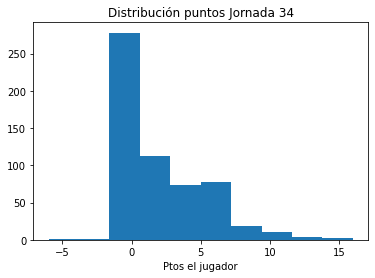

In [6]:
plt.hist(j_34['J_Actual'], bins=10);
plt.title('Distribución puntos Jornada 34')
plt.xlabel('Ptos el jugador');

#### Distribución de las predicciones de cada uno de los modelos

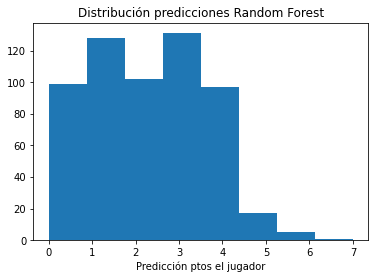

In [7]:
plt.hist(round(preds.rfr), bins=8);
plt.title('Distribución predicciones Random Forest')
plt.xlabel('Predicción ptos el jugador');

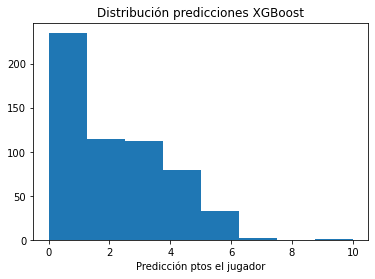

In [8]:
plt.hist(round(preds.xgb), bins=8);
plt.title('Distribución predicciones XGBoost')
plt.xlabel('Predicción ptos el jugador');

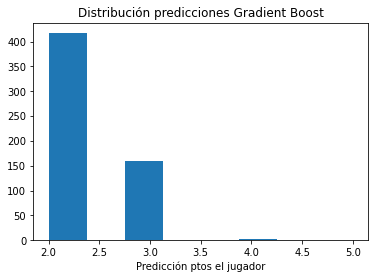

In [9]:
plt.hist(round(preds.gb), bins=8);
plt.title('Distribución predicciones Gradient Boost')
plt.xlabel('Predicción ptos el jugador');

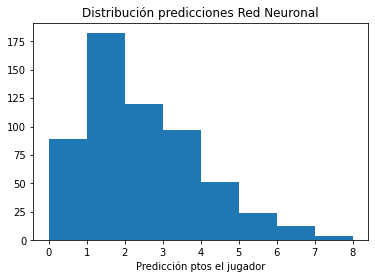

In [10]:
plt.hist(round(preds.rnn), bins=8);
plt.title('Distribución predicciones Red Neuronal')
plt.xlabel('Predicción ptos el jugador');


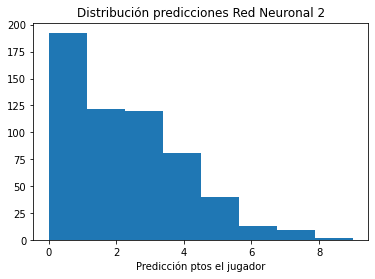

In [11]:
plt.hist(round(preds.rnn2), bins=8);
plt.title('Distribución predicciones Red Neuronal 2')
plt.xlabel('Predicción ptos el jugador');

### Generamos los onces ideales de cada equipo y comparamos la predicción con los datos reales

In [12]:
eleven_rf = comunio_pred_lib.once_ideal_rf(preds,3,4,3)
eleven_xgb = comunio_pred_lib.once_ideal_xbgr(preds,3,4,3)
eleven_gb = comunio_pred_lib.once_ideal_gb(preds,3,4,3)
eleven_rnn = comunio_pred_lib.once_ideal_rnn(preds,3,4,3)
eleven_rnn2 = comunio_pred_lib.once_ideal_rnn2(preds,3,4,3)

In [14]:
print('Totales xgb: ', sum(eleven_xgb.xgb), ', real: ', 
      #sum(eleven_xgb.J_Actual)
     )
print('Totales rfr: ', sum(eleven_rf.rfr), ', real: ', 
      #sum(eleven_rf.J_Actual)
     )
print('Totales gb: ', sum(eleven_gb.gb), ', real: ', 
      #sum(eleven_gb.J_Actual)
     )
print('Totales rnn: ', sum(eleven_rnn.rnn), ', real: ', 
      #sum(eleven_rnn.J_Actual)
     )
print('Totales rnn2: ', sum(eleven_rnn2.rnn2), ', real: ', 
      #sum(eleven_rnn2.J_Actual)
     )

Totales xgb:  67.0 , real: 
Totales rfr:  57.0 , real: 
Totales gb:  37.0 , real: 
Totales rnn:  69.0 , real: 
Totales rnn2:  77.0 , real: 


In [15]:
eleven_gb

,Player,Position,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
467,Jeremías Ledesma,PT,4.0,4.0,3.0,4.0,4.0,8.4
108,Jordi Alba,DF,5.0,5.0,3.0,7.0,8.0,8.8
554,Kounde,DF,4.0,5.0,3.0,5.0,6.0,7.4
233,Catena,DF,4.0,4.0,3.0,4.0,4.0,6.6
118,Sergio Busquets,MD,5.0,5.0,3.0,7.0,7.0,8.6
561,Rakitic,MD,5.0,5.0,3.0,5.0,6.0,8.0
13,Muniain,MD,5.0,5.0,3.0,5.0,6.0,7.6
329,Fekir,MD,6.0,6.0,3.0,6.0,7.0,7.4
130,Ferrán Torres,DL,6.0,10.0,5.0,6.0,7.0,4.0
221,Benzema,DL,7.0,7.0,4.0,8.0,9.0,8.2


In [16]:
eleven_rnn

,Player,Position,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
25,Oblak,PT,4.0,4.0,3.0,5.0,5.0,5.8
108,Jordi Alba,DF,5.0,5.0,3.0,7.0,8.0,8.8
109,Ronald Araujo,DF,4.0,5.0,3.0,6.0,7.0,5.2
554,Kounde,DF,4.0,5.0,3.0,5.0,6.0,7.4
118,Sergio Busquets,MD,5.0,5.0,3.0,7.0,7.0,8.6
329,Fekir,MD,6.0,6.0,3.0,6.0,7.0,7.4
330,Canales,MD,5.0,7.0,3.0,6.0,7.0,7.0
395,Parejo,MD,5.0,5.0,3.0,6.0,6.0,6.8
221,Benzema,DL,7.0,7.0,4.0,8.0,9.0,8.2
127,Dembélé,DL,5.0,5.0,3.0,7.0,7.0,4.8


### Ahora vamos a testear con una plantilla real la mía del comunio a ver que alineación recomienda

    Primero generamos un df a partir de los datos de prediciones que tenemos, y los filtramos con los jugadores que tengo en mi plantilla de comunio

In [24]:
squad = ['Courtois', 'Bono',
         'Balliu', 
         'Fran García',
         'Maffeo',
         'Ronald Araujo', 
         'Alderete', 'Manu Sánchez', 
         #'Giménez', Está lesionado o tenía pocas posibilidades de jugar
         #'Yéremi',  
         'Gavi',  
         'Modric',  
         'Brais', 'Papu Gómez', 'Dani Rodríguez', 'Pere Milla', 'Cervi', 'Berenguer',
         'Vinícius Júnior', 'Aubameyang', 
         #'Sancet',  
         'Morales']
df_squad_kike = pd.DataFrame()
for player in squad:
    #print (player)
    for p in preds.Player:
        if player in p:
            #print('encontrado')
            add_player = pd.DataFrame(preds.loc[preds.Player==p])
            #print(add_player)
            df_squad_kike = df_squad_kike.append(add_player)
print(len(squad),len(df_squad_kike))

df_squad_kike.at[518,'Position'] = 'MD'
df_squad_kike = round(df_squad_kike)
df_squad_kike

19 19


,Player,Position,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
199,Courtois,PT,4.0,5.0,3.0,4.0,5.0,3.0
550,Bono,PT,4.0,4.0,3.0,4.0,4.0,3.0
235,Balliu,DF,2.0,2.0,2.0,2.0,3.0,1.0
234,Fran García,DF,3.0,3.0,3.0,3.0,4.0,4.0
291,Maffeo,DF,3.0,3.0,2.0,2.0,3.0,2.0
109,Ronald Araujo,DF,4.0,5.0,3.0,6.0,7.0,5.0
413,Omar Alderete,DF,3.0,3.0,3.0,3.0,4.0,3.0
53,Manu Sánchez,DF,3.0,3.0,2.0,3.0,3.0,3.0
120,Gavi,MD,4.0,3.0,3.0,5.0,6.0,4.0
214,Modric,MD,4.0,4.0,3.0,4.0,5.0,3.0


In [25]:
xgb_eleven_kike = round(comunio_pred_lib.once_ideal_xbgr(df_squad_kike,3,4,3))

rf_eleven_kike = round(comunio_pred_lib.once_ideal_rf(df_squad_kike,3,4,3))

gb_eleven_kike = round(comunio_pred_lib.once_ideal_gb(df_squad_kike,3,4,3))

rnn_eleven_kike = round(comunio_pred_lib.once_ideal_rnn(df_squad_kike,3,4,3))

rnn2_eleven_kike = round(comunio_pred_lib.once_ideal_rnn2(df_squad_kike,3,4,3))

print('Totales xgb: ', sum(xgb_eleven_kike.xgb), ', real: ', 
      #sum(xgb_eleven_kike.J_Actual)
     )
print('Totales rfr: ', sum(rf_eleven_kike.rfr), ', real: ', 
      #sum(rf_eleven_kike.J_Actual)
     )
print('Totales gb: ', sum(gb_eleven_kike.gb), ', real: ', 
      #sum(gb_eleven_kike.J_Actual)
     )
print('Totales rnn: ', sum(rnn_eleven_kike.rnn), ', real: ', 
      #sum(rnn_eleven_kike.J_Actual)
     )
print('Totales rnn2: ', sum(rnn2_eleven_kike.rnn2), ', real: ', 
      #sum(rnn2_eleven_kike.J_Actual)
     )

Totales xgb:  46.0 , real: 
Totales rfr:  45.0 , real: 
Totales gb:  34.0 , real: 
Totales rnn:  48.0 , real: 
Totales rnn2:  56.0 , real: 


In [26]:
gb_eleven_kike


,Player,Position,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
199,Courtois,PT,4.0,5.0,3.0,4.0,5.0,3.0
109,Ronald Araujo,DF,4.0,5.0,3.0,6.0,7.0,5.0
234,Fran García,DF,3.0,3.0,3.0,3.0,4.0,4.0
413,Omar Alderete,DF,3.0,3.0,3.0,3.0,4.0,3.0
535,Franco Cervi,MD,4.0,4.0,3.0,3.0,4.0,6.0
120,Gavi,MD,4.0,3.0,3.0,5.0,6.0,4.0
518,Pere Milla,MD,3.0,4.0,3.0,3.0,3.0,4.0
214,Modric,MD,4.0,4.0,3.0,4.0,5.0,3.0
222,Vinícius Júnior,DL,5.0,6.0,4.0,6.0,7.0,3.0
283,Morales,DL,4.0,3.0,3.0,4.0,4.0,8.0


In [27]:
rnn2_eleven_kike

,Player,Position,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
199,Courtois,PT,4.0,5.0,3.0,4.0,5.0,3.0
109,Ronald Araujo,DF,4.0,5.0,3.0,6.0,7.0,5.0
234,Fran García,DF,3.0,3.0,3.0,3.0,4.0,4.0
413,Omar Alderete,DF,3.0,3.0,3.0,3.0,4.0,3.0
120,Gavi,MD,4.0,3.0,3.0,5.0,6.0,4.0
214,Modric,MD,4.0,4.0,3.0,4.0,5.0,3.0
535,Franco Cervi,MD,4.0,4.0,3.0,3.0,4.0,6.0
563,Papu Gómez,MD,4.0,3.0,3.0,4.0,4.0,3.0
222,Vinícius Júnior,DL,5.0,6.0,4.0,6.0,7.0,3.0
128,Aubameyang,DL,6.0,5.0,3.0,6.0,6.0,3.0


In [29]:
xgb_eleven_kike

,Player,Position,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
199,Courtois,PT,4.0,5.0,3.0,4.0,5.0,3.0
109,Ronald Araujo,DF,4.0,5.0,3.0,6.0,7.0,5.0
234,Fran García,DF,3.0,3.0,3.0,3.0,4.0,4.0
413,Omar Alderete,DF,3.0,3.0,3.0,3.0,4.0,3.0
535,Franco Cervi,MD,4.0,4.0,3.0,3.0,4.0,6.0
518,Pere Milla,MD,3.0,4.0,3.0,3.0,3.0,4.0
214,Modric,MD,4.0,4.0,3.0,4.0,5.0,3.0
534,Brais Méndez,MD,4.0,4.0,3.0,2.0,3.0,3.0
222,Vinícius Júnior,DL,5.0,6.0,4.0,6.0,7.0,3.0
128,Aubameyang,DL,6.0,5.0,3.0,6.0,6.0,3.0


## Conclusiones

El peor modelo es sin duda el gradient boost, ya que prácticamente asigna la misma puntución a todos los jugadores.
El resto de modelos funcionan bastante bien y aunque el rnn2 no es el que mejores resultados obtiene en cuanto error absoluto es el que mejor generaliza y se acerca más a la realidad, solo hay que comparar las distribuciones de la puntuación real y de la rnn2 para ver que son las más similares.

In [38]:
real_madrid = preds.loc[preds.Team=='Real Madrid']
levante = preds.loc[preds.Team=='Levante']

In [35]:
rnn2_eleven_rm = round(comunio_pred_lib.once_ideal_rnn2(real_madrid,4,3,3))

In [36]:
rnn2_eleven_rm

,Player,Position,Team,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
199,Courtois,PT,Real Madrid,4.0,5.0,3.0,4.0,5.0,3.0
201,Éder Militão,DF,Real Madrid,4.0,4.0,3.0,4.0,5.0,4.0
203,Lucas Vázquez,DF,Real Madrid,3.0,3.0,3.0,3.0,4.0,6.0
205,Nacho Fernández,DF,Real Madrid,4.0,4.0,3.0,3.0,4.0,5.0
202,Alaba,DF,Real Madrid,4.0,4.0,3.0,3.0,4.0,3.0
213,Kroos,MD,Real Madrid,4.0,4.0,3.0,5.0,6.0,5.0
212,Casemiro,MD,Real Madrid,5.0,5.0,3.0,5.0,6.0,2.0
216,Camavinga,MD,Real Madrid,4.0,4.0,3.0,5.0,5.0,7.0
221,Benzema,DL,Real Madrid,7.0,7.0,4.0,8.0,9.0,8.0
222,Vinícius Júnior,DL,Real Madrid,5.0,6.0,4.0,6.0,7.0,3.0


In [37]:
real_madrid

,Player,Position,Team,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
199,Courtois,PT,Real Madrid,4.0,5.0,3.0,4.0,5.0,3.4
200,Lunin,PT,Real Madrid,1.0,1.0,2.0,1.0,1.0,0.4
201,Éder Militão,DF,Real Madrid,4.0,4.0,3.0,4.0,5.0,3.6
202,Alaba,DF,Real Madrid,4.0,4.0,3.0,3.0,4.0,2.8
203,Lucas Vázquez,DF,Real Madrid,3.0,3.0,3.0,3.0,4.0,5.6
204,Carvajal,DF,Real Madrid,3.0,3.0,3.0,2.0,3.0,3.4
205,Nacho Fernández,DF,Real Madrid,4.0,4.0,3.0,3.0,4.0,5.2
206,Ferland Mendy,DF,Real Madrid,3.0,3.0,2.0,2.0,3.0,1.4
207,Marcelo,DF,Real Madrid,2.0,2.0,2.0,1.0,2.0,1.8
208,Miguel Gutiérrez,DF,Real Madrid,0.0,0.0,2.0,1.0,1.0,0.0


In [40]:
levante

,Player,Position,Team,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
255,Dani Cárdenas,PT,Levante,3.0,3.0,2.0,2.0,3.0,3.6
256,Dani Cárdenas,PT,Levante,3.0,3.0,2.0,2.0,3.0,3.6
257,Jorge Miramón,DF,Levante,3.0,2.0,2.0,2.0,3.0,4.0
258,Jorge Miramón,DF,Levante,3.0,2.0,2.0,2.0,3.0,4.0
259,Aitor Fernández,PT,Levante,1.0,1.0,2.0,1.0,1.0,0.0
260,Rúben Vezo,DF,Levante,3.0,2.0,2.0,2.0,3.0,3.4
261,Óscar Duarte,DF,Levante,3.0,3.0,3.0,2.0,4.0,5.2
262,Rober Pier,DF,Levante,3.0,2.0,2.0,2.0,3.0,3.0
263,Clerc,DF,Levante,1.0,1.0,2.0,1.0,2.0,0.0
264,Son,DF,Levante,3.0,2.0,2.0,2.0,3.0,2.8


In [41]:
rnn2_eleven_lv = round(comunio_pred_lib.once_ideal_rnn2(levante,4,3,3))

In [42]:
rnn2_eleven_lv

,Player,Position,Team,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
255,Dani Cárdenas,PT,Levante,3.0,3.0,2.0,2.0,3.0,4.0
261,Óscar Duarte,DF,Levante,3.0,3.0,3.0,2.0,4.0,5.0
257,Jorge Miramón,DF,Levante,3.0,2.0,2.0,2.0,3.0,4.0
258,Jorge Miramón,DF,Levante,3.0,2.0,2.0,2.0,3.0,4.0
260,Rúben Vezo,DF,Levante,3.0,2.0,2.0,2.0,3.0,3.0
273,Pepelu,MD,Levante,3.0,4.0,3.0,3.0,4.0,6.0
274,Melero,MD,Levante,3.0,3.0,3.0,3.0,4.0,4.0
275,Bardhi,MD,Levante,3.0,3.0,2.0,1.0,3.0,2.0
283,Morales,DL,Levante,4.0,3.0,3.0,4.0,4.0,8.0
284,Roger,DL,Levante,3.0,3.0,3.0,2.0,3.0,2.0


In [43]:
rnn2_eleven_rm

,Player,Position,Team,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
199,Courtois,PT,Real Madrid,4.0,5.0,3.0,4.0,5.0,3.0
201,Éder Militão,DF,Real Madrid,4.0,4.0,3.0,4.0,5.0,4.0
203,Lucas Vázquez,DF,Real Madrid,3.0,3.0,3.0,3.0,4.0,6.0
205,Nacho Fernández,DF,Real Madrid,4.0,4.0,3.0,3.0,4.0,5.0
202,Alaba,DF,Real Madrid,4.0,4.0,3.0,3.0,4.0,3.0
213,Kroos,MD,Real Madrid,4.0,4.0,3.0,5.0,6.0,5.0
212,Casemiro,MD,Real Madrid,5.0,5.0,3.0,5.0,6.0,2.0
216,Camavinga,MD,Real Madrid,4.0,4.0,3.0,5.0,5.0,7.0
221,Benzema,DL,Real Madrid,7.0,7.0,4.0,8.0,9.0,8.0
222,Vinícius Júnior,DL,Real Madrid,5.0,6.0,4.0,6.0,7.0,3.0


In [44]:
'Real Madrid: ', sum(rnn2_eleven_rm.rnn2), 'Levante: ', sum(rnn2_eleven_lv.rnn2)

('Real Madrid: ', 60.0, 'Levante: ', 36.0)

In [47]:

j_33.Team.unique()

array(['Athletic Club', 'Atlético Madrid', 'Osasuna', 'Espanyol',
       'Barcelona', 'Getafe', 'Granada', 'Real Madrid', 'Rayo Vallecano',
       'Levante', 'Mallorca', 'Betis', 'Real Sociedad', 'Villarreal',
       'Valencia', 'Alavés', 'Cádiz', 'Elche', 'Celta Vigo', 'Sevilla'],
      dtype=object)